In [1]:
import matplotlib.pylab as pl
import matplotlib.animation as ani
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob
import os

import cv2
import numpy as np

In [3]:
def _unglob_files(files):
    """Resolves file path patterns (like /some/folder/*.avi) with actual file names."""
    files_found = []
    for file in files:
        globs_list = glob.glob(file)
        if not os.path.exists(file) and (len(globs_list) > 0):
            files_found.extend(globs_list)
        else:
            files_found.append(file)
    return files_found

In [4]:
INPUT_VIDEOS = sorted(_unglob_files([os.path.join('/some/folder', '*.avi')]))
INPUT_FILE_NAME = INPUT_VIDEOS[1] # forest.avi
INPUT_FRAMES_MAX = 2

In [5]:
cap = cv2.VideoCapture(INPUT_FILE_NAME)

lk_params = dict(
    winSize = (15, 15), maxLevel = 2, criteria = (cv2.TermCriteria_EPS | cv2.TermCriteria_COUNT, 10, 0.03)
)

color = np.array([255, 255, 255]).astype(np.uint8)

# First frame
_, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

p0 = None
p1 = np.array([[[560.0, 250.0]]]).astype(np.float32)
mask = np.zeros_like(old_frame)

frames = []
track_frames = []

for i in range(INPUT_FRAMES_MAX):
    _, frame = cap.read()
    if frame is None:
        break
    
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    if p0 is not None:
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    
        good_old, good_new = p0[st == 1], p1[st == 1]
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            mask = cv2.line(mask, (a, b), (c, d), color[i].tolist(), 2)
    else:
        good_new = p1
    
    frames.append(frame.copy())
    track_frames.append(mask.copy())
    
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

In [6]:
SHOW_TRACKS = True

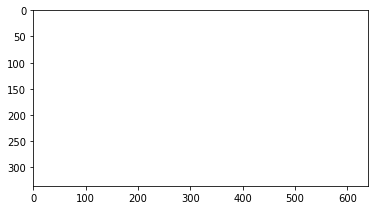

In [7]:
ims = []
fig = pl.figure()

for i in range(len(frames)):
    if SHOW_TRACKS:
        img = cv2.add(frames[i], track_frames[i])
    else:
        img = frames[i]
    imgs = pl.imshow(img, animated = True)
    ims.append([imgs,])

anim = ani.ArtistAnimation(fig, ims, interval = 100, repeat_delay = 1000)

from IPython.display import HTML
HTML(anim.to_jshtml())
#HTML(anim.to_html5_video())

In [8]:
output_folder_base = os.path.dirname(os.path.abspath(INPUT_FILE_NAME))
output_folder_name = (os.path.split(os.path.abspath(INPUT_FILE_NAME))[-1]).split(os.path.extsep)[0] + '_out'

output_folder_path = os.path.join(output_folder_base, output_folder_name)
if not os.path.isdir(output_folder_path):
    os.mkdir(output_folder_path)

for i in range(len(frames)):
    if SHOW_TRACKS:
        img = cv2.add(frames[i], track_frames[i])
    else:
        img = frames[i]
        
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    output_file_path = os.path.join(output_folder_path, (output_folder_name + '_%06d.png') % (i + 1))
    cv2.imwrite(output_file_path, img)